## Time series exploration of metrics
> This file's purpose is to **explore** the time series of the metrics that'll be used for creating the portfolios

### Index
[ROA](##ROA)

In [1]:
import os

import pickle
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

# Add cwd/.. to path so the imports to user defined packages work
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.extract_data.metrics_extractor import MetricsExtractor
from src.extract_data.extract_classification import ClassificationExtractor
from src.extract_data.returns_calculator import StockReturnsCalculator
from src.configs.file_style_configs_by_metric import file_style_configs_by_metric

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

## ROA

### Data extraction

In [2]:
# Set up extractor for all metrics, this is the only instance we need to have of the extractor
extractor = MetricsExtractor(os.path.join("..", "data", "companies_data"), file_style_configs_by_metric)

In [3]:
# Load or extract ROA data. TODO: Refactor this logic into the extract method inside of MetricsExtractor
name_of_metric = "Pretax ROA"
file_name = f"{name_of_metric.lower()}_data.pickle"
full_file_path= os.path.join("..", "data", "pickled_data", file_name)
try:
    # Deserialize
    with open(full_file_path, "rb") as infile:
        ROA_df = pickle.load(infile)

except FileNotFoundError:
    extractor.extract(name_of_metric)
    ROA_df = extractor.get_dataframe()

    # Serialize
    with open(full_file_path, "wb") as outfile:
        pickle.dump(ROA_df, outfile)

ROA_df.index = pd.to_datetime(ROA_df.index) # After being pickled, the index changes type # TODO: Check what's up with this

# Load or extract sector and industry for every company
file_name = f"companies_classification_data.pickle"
full_file_path= os.path.join("..", "data", "pickled_data", file_name)
if os.path.exists(full_file_path):
    try:
        with open(full_file_path, "rb") as infile:
            companies_classification = pickle.load(infile)
    except (FileNotFoundError, pickle.PickleError):
        companies_classification = pd.DataFrame()
else:
    companies_classification = pd.DataFrame()

missing_classification = list(set(ROA_df.columns.to_list()) - set(companies_classification.index.to_list()))
if missing_classification:
    classification_extractor = ClassificationExtractor(os.path.join("..", "data", "companies_classification", "classification.csv"))
    missing_companies_classification = classification_extractor.extract(missing_classification, )
    companies_classification = pd.concat([companies_classification, missing_companies_classification])

    with open(full_file_path, "wb") as outfile:
        pickle.dump(companies_classification, outfile)

### Data clean up


Number of NaNs: 10157, number of values: 35673
Number of '-'s: 33


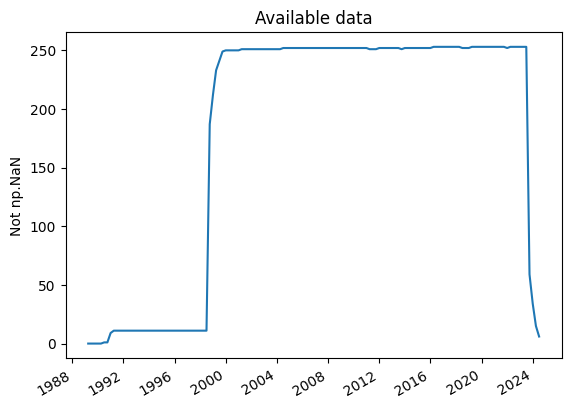

In [4]:
print(f"Number of NaNs: {ROA_df.isna().sum().sum()}, number of values: {ROA_df.size}")
print(f"Number of '-'s: {ROA_df[ROA_df == '-'].count().sum()}") # TODO: How should we deal with "-"s??? How to impute missing values?

# Let's the count of available data for every date
nan_count_per_row = ROA_df.notna().sum(axis=1)
nan_count_per_row.plot(title="Available data", ylabel="Not np.NaN")
plt.show()

In [5]:
# Most of out data starts from the 2000s
ROA_df = ROA_df[ROA_df.index.year >= 2000]

# For some reason we have data from the future
ROA_df = ROA_df[ROA_df.index.year < 2024] # We also have data from the next months so, TODO: remove it

In [6]:
# Let's have an overview of the whole data frame
ROA_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2000-03-31 to 2023-12-31
Columns: 253 entries, AAPL to ZION
dtypes: float64(244), object(9)
memory usage: 190.5+ KB


C:\Users\mateo\AppData\Local\Temp\ipykernel_12724\2207094881.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ROA_df.mean(axis=1).plot(kind="line", ax=axes[2])
C:\Users\mateo\AppData\Local\Temp\ipykernel_12724\2207094881.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ROA_df.std(axis=1).plot(kind="line", ax=axes[2])


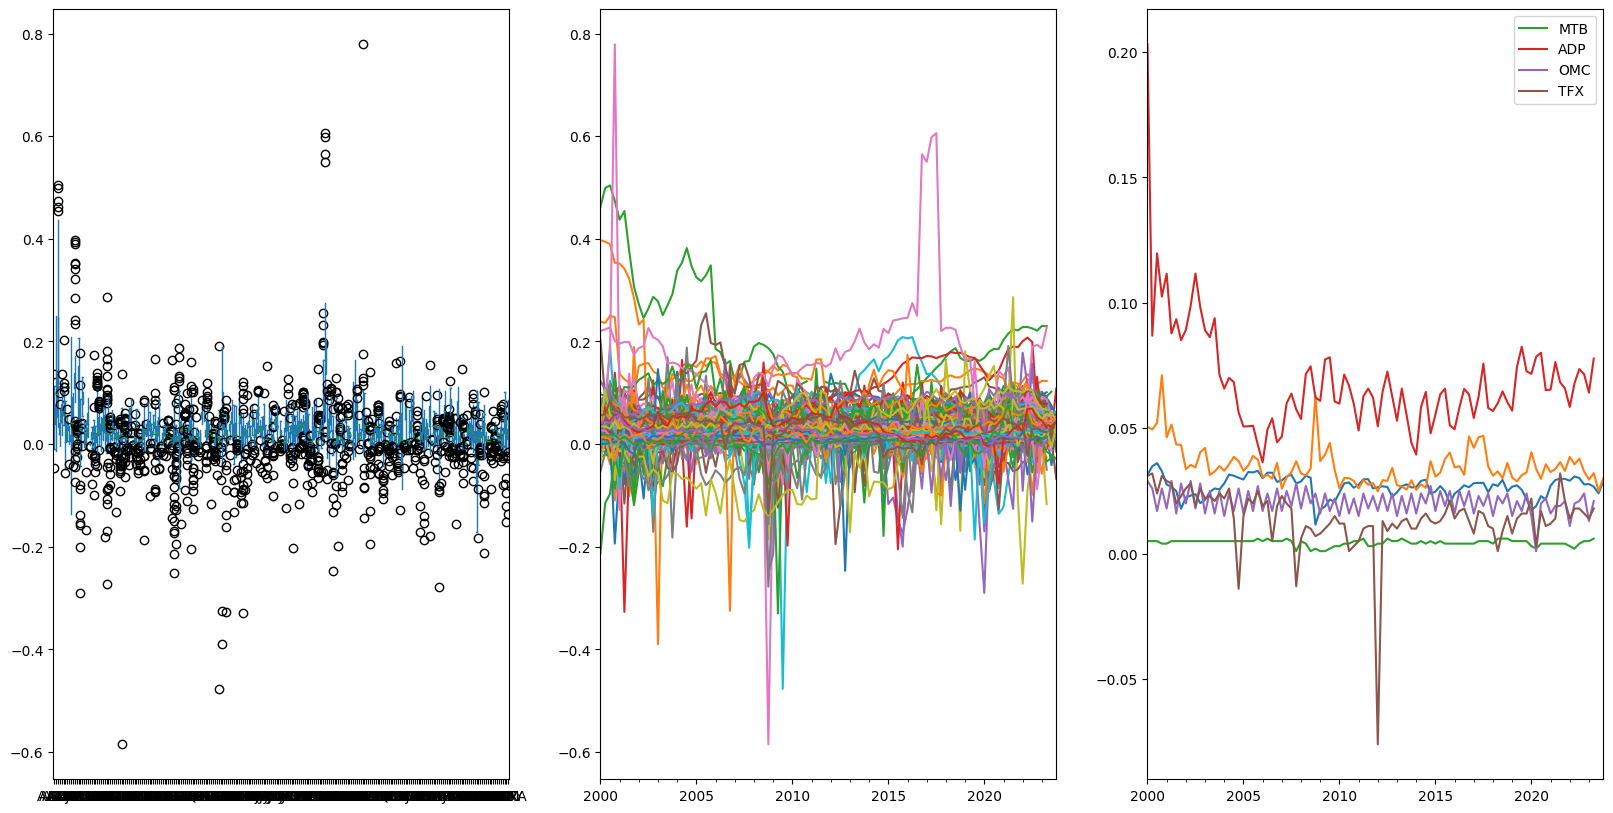

,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEP,AJG,ALK,AMAT,AMGN,AON,AOS,APA,APD,ATO,AVY,AZO,BAC,BALL,BAX,BA,BBWI,BBY,BDX,BEN,BIIB,BIO,BMY,BRK,BRO,CAG,CAH,CAT,CCL,CDNS,CHD,CINF,CI,CLX,CL,CMA,CMCSA,CMI,CMS,CNP,COO,COP,COST,CPB,CSCO,CSX,CTAS,CTRA,CVS,CVX,C,DE,DHR,DIS,DOV,DTE,DUK,DVN,DXC,D,EA,ECL,ED,EFX,EIX,EMR,EOG,EQT,ES,ETN,ETR,EXC,EXPD,FAST,FDX,FICO,FI,FMC,FRT,F,GD,GEN,GE,GILD,GIS,GLW,GL,GPC,GWW,HAL,HAS,HBAN,HD,HES,HOLX,HON,HPQ,HRL,HST,HSY,HUM,IBM,IDXX,IEX,IFF,INTC,IPG,IP,ITW,JBHT,JCI,JKHY,JNJ,JPM,J,KEY,KIM,KLAC,KO,KR,K,LEN,LHX,LH,LLY,LMT,LNT,LOW,LRCX,LUV,L,MAS,MCD,MDT,MGM,MKC,MMC,MNST,MO,MRK,MRO,MSFT,MSI,MTB,MU,NDSN,NEE,NEM,NI,NKE,NOC,NSC,NTRS,NUE,NVR,ODFL,OKE,OMC,ORCL,OXY,PAYX,PCAR,PCG,PEAK,PEG,PEP,PFE,PGR,PG,PHM,PH,PNC,PNR,PNW,PPG,PPL,PSA,PTC,QCOM,REGN,RF,RHI,RJF,ROK,ROL,ROST,RTX,RVTY,SCHW,SEE,SHW,SLB,SNA,SO,SPGI,STT,SYK,SYY,TAP,TER,TFX,TGT,TJX,TMO,TRMB,TROW,TRV,TSN,TT,TXN,TXT,TYL,T,UDR,UHS,UNP,VFC,VLO,VMC,VRTX,VTRS,VZ,WBA,WDC,WEC,WELL,WFC,WHR,WMB,WMT,WM,WRB,WST,WY,XOM,XRAY,ZBRA
count,95.000000,94.000000,91.000000,94.000000,93.000000,94.000000,96.000000,93.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,94.000000,95.000000,94.000000,94.000000,94.000000,94.000000,96.000000,96.000000,95.000000,95.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,95.000000,96.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,95.000000,94.000000,95.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,95.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,95.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.00000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,95.000000,94.000000,95.000000,95.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,96.000000,94.000000,94.000000,95.000000,94.000000,94.000000,96.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,96.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,95.000000,95.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,95.000000,94.000000,94.000000,94.000000,95.000000,95.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,96.000000,96.000000,94.000000,94.000000,94.000000,94.000000,95.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,93.00000,94.000000,94.000000,94.000000,94.000000,94.000000,95.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,96.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.054295,0.096595,0.197246,0.031489,0.059859,0.068635,0.023021,0.034774,0.013053,0.047291,0.037979,0.136870,0.012043,0.096569,0.018511,0.087880,0.012242,0.020596,0.050684,0.002840,0.014553,0.024255,0.011723,0.041781,0.031625,0.026347,0.038926,0.038979,0.023298,0.033372,0.013819,0.031447,0.015198,0.013927,0.017011,0.008149,0.014670,0.031340,0.010574,0.009734,0.044083,0.063798,0.003702,0.012957,0.028915,0.004319,0.006298,0.018936,0.025191,0.025789,0.033621,0.033802,0.019649,0.037781,0.022309,0.022702,0.034096,0.002574,0.016242,0.024138,0.022305,0.025160,0.00785

In [7]:
# Overview of the time series for every company
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

ROA_df.plot(kind="box", ax=axes[0], title="")
ROA_df.plot(kind="line", ax=axes[1], legend=False)
ROA_df.mean(axis=1).plot(kind="line", ax=axes[2])
ROA_df.std(axis=1).plot(kind="line", ax=axes[2])
ROA_df[["MTB", "ADP", "OMC", "TFX"]].plot(kind="line", ax=axes[2])
plt.show()

plt.show()
ROA_df.describe()

### One company/time series exploration

In [8]:
# Let's take one at random
symbol = "MSFT"
time_series = ROA_df[symbol].copy()

df = {
    "date": [],
    "month": [],
    "year": [],
    "value": []
}
df["date"] = pd.to_datetime(time_series.index.to_list(), format='%Y-%m-%d %H:%M:%S')
df["month"] = time_series.index.month.to_list()
df["year"] = time_series.index.year.to_list()
df["value"] = time_series.to_list()
df = pd.DataFrame(df)

study_period = (2000, 2020)
df = df.loc[(df.year >= study_period[0]) & (df.year < study_period[1])]

print([True for value in df.value if value == "-"]) # Pesky "-"s

[]


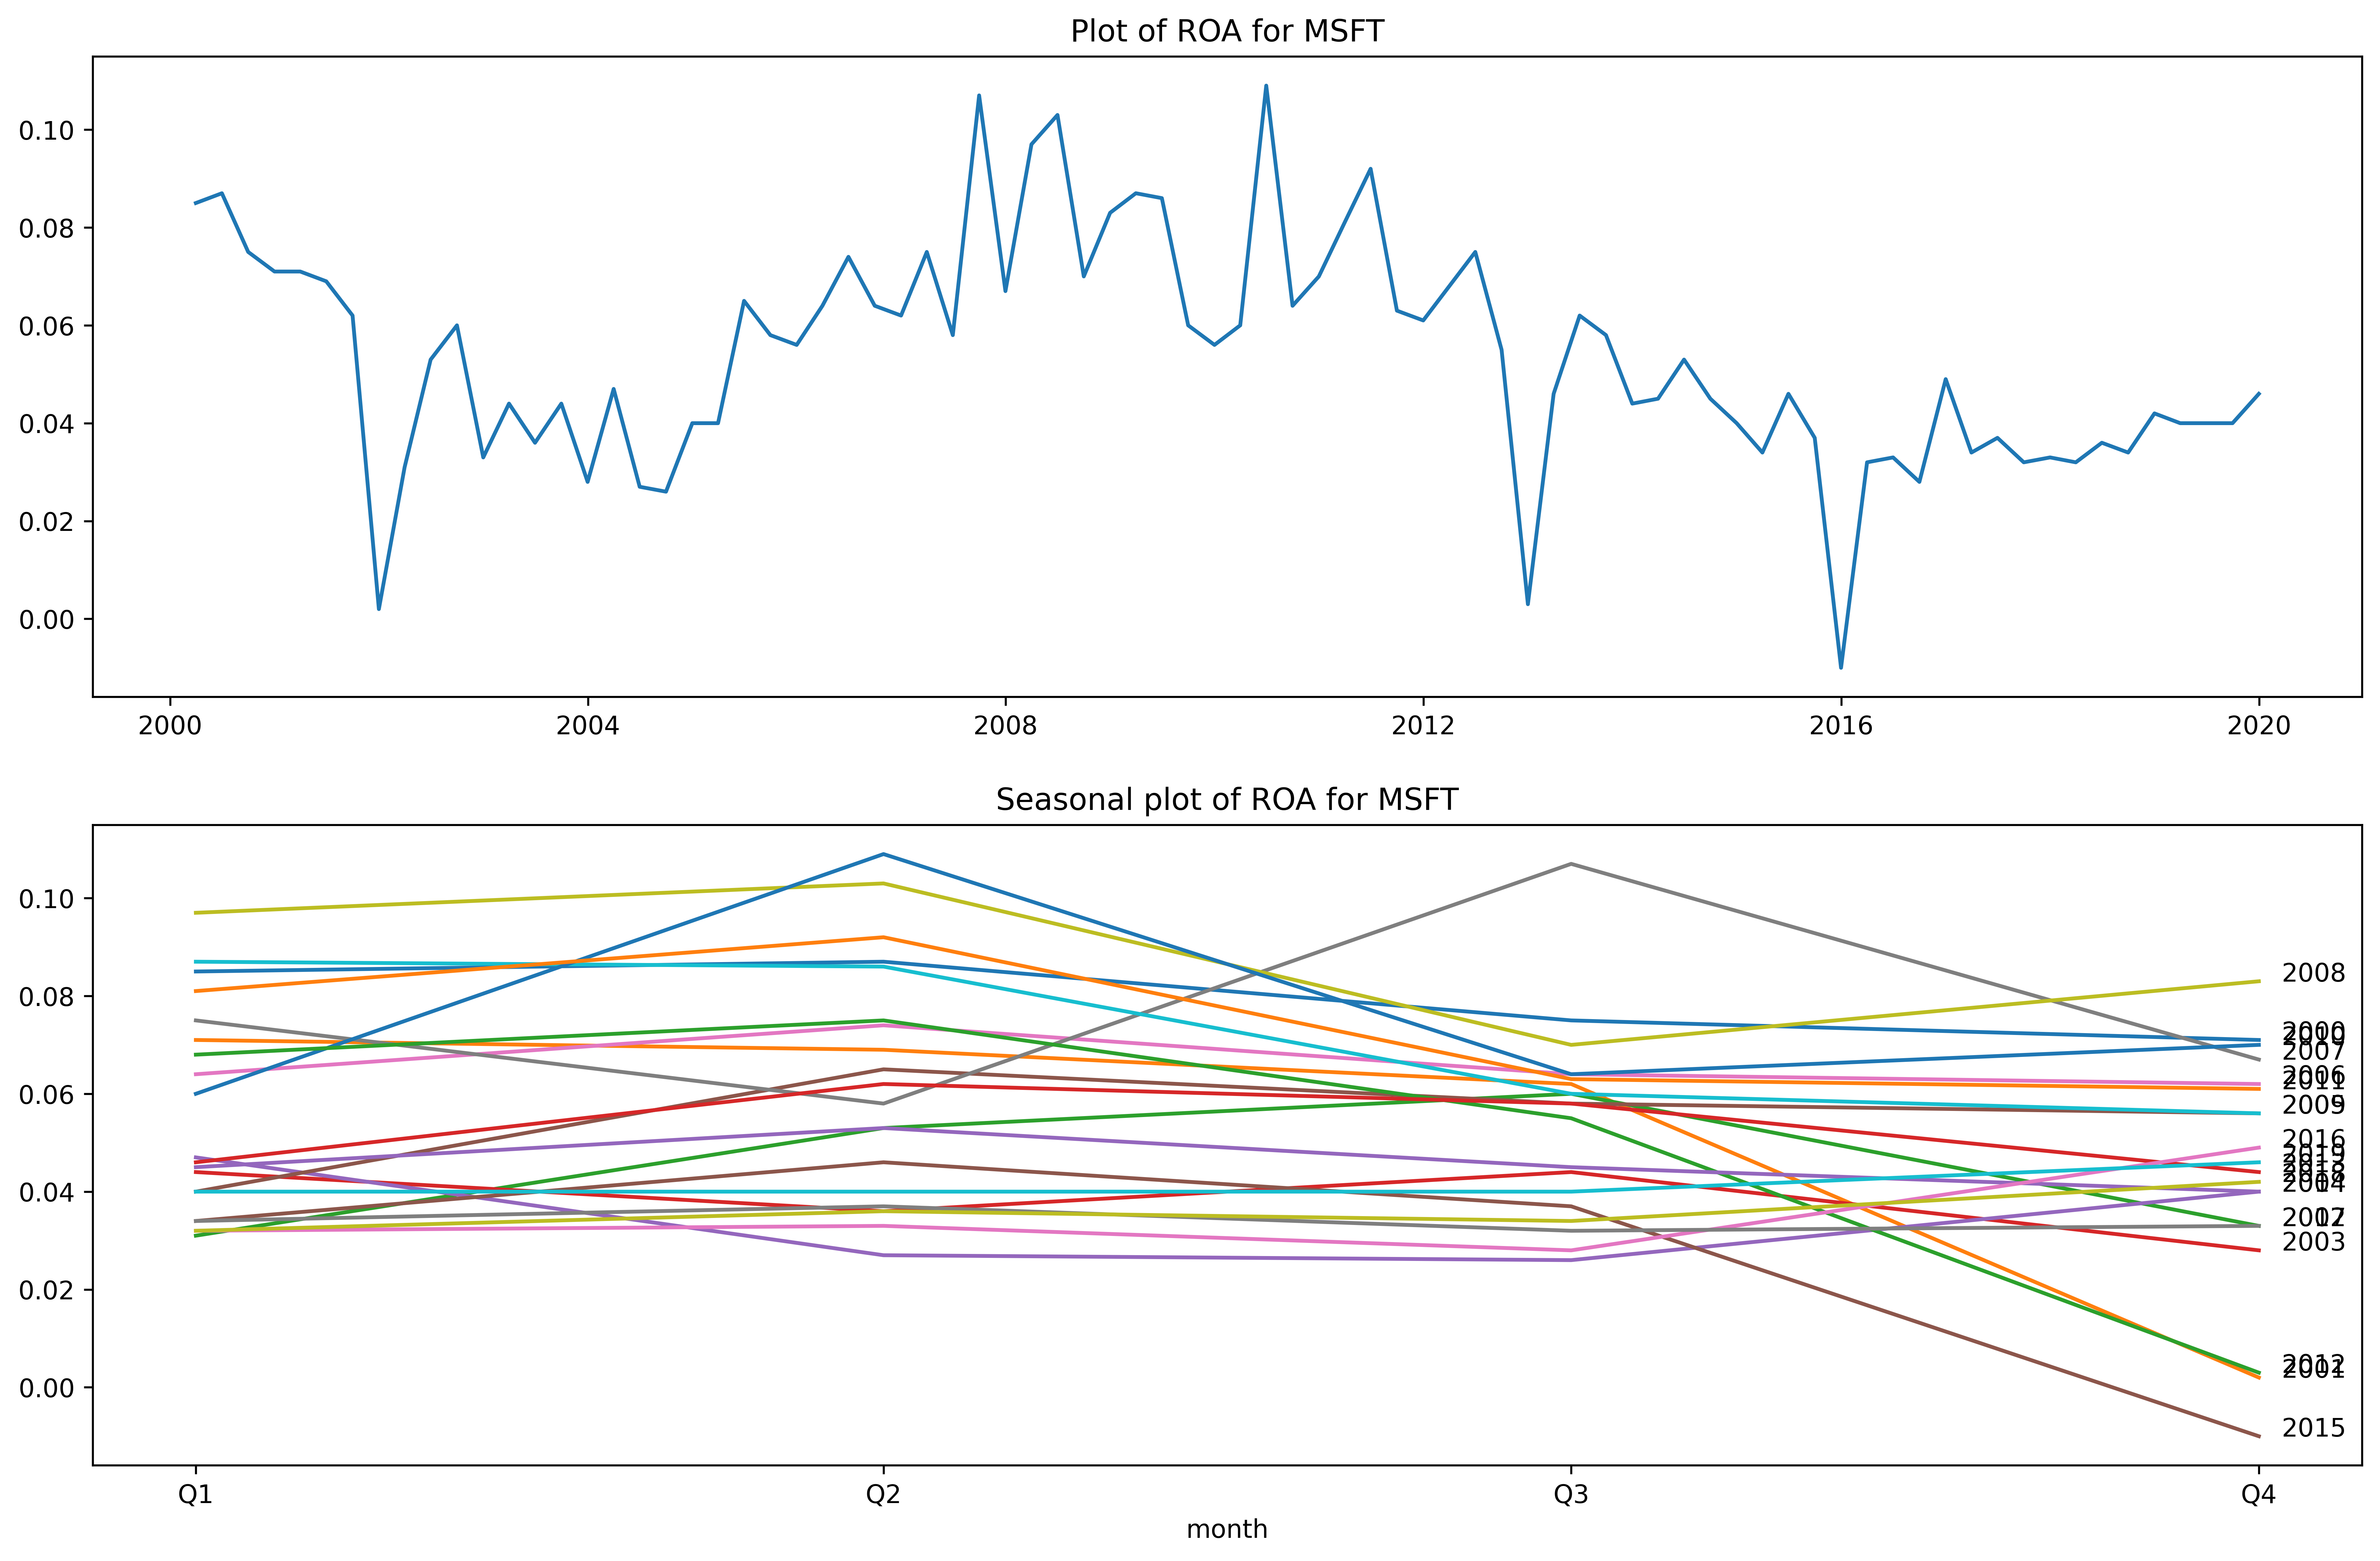

In [9]:
fig, ax = plt.subplots(2 ,1, figsize=(16,10), dpi=600)

# Time series plot
ax[0].plot(df["date"], df["value"])
ax[0].set_title(f"Plot of ROA for {symbol}")

# Seasonal plot
df.pivot(index="month", columns="year", values="value").plot(ax=ax[1], legend=False)
lines = ax[1].get_lines()
for line in lines:
    last_y = line.get_ydata()[-1]
    last_x = line.get_xdata()[-1]

    ax[1].text(last_x + 0.1, last_y, line.get_label())
ax[1].set_title(f"Seasonal plot of ROA for {symbol}")
qs = ["Q1", "Q2", "Q3", "Q4"]
ax[1].set_xticks(range(3,12+1,3)) # For placing xticklabels correctly
ax[1].set_xticklabels(qs)

plt.show()

A somewhat clear trend can be see in june for the seasonal plot unfortunatelly there does not seem to be enough data points per year to tell if there is a clear trend or not, at least visually. Also, there is a clear trend in the time series plot.

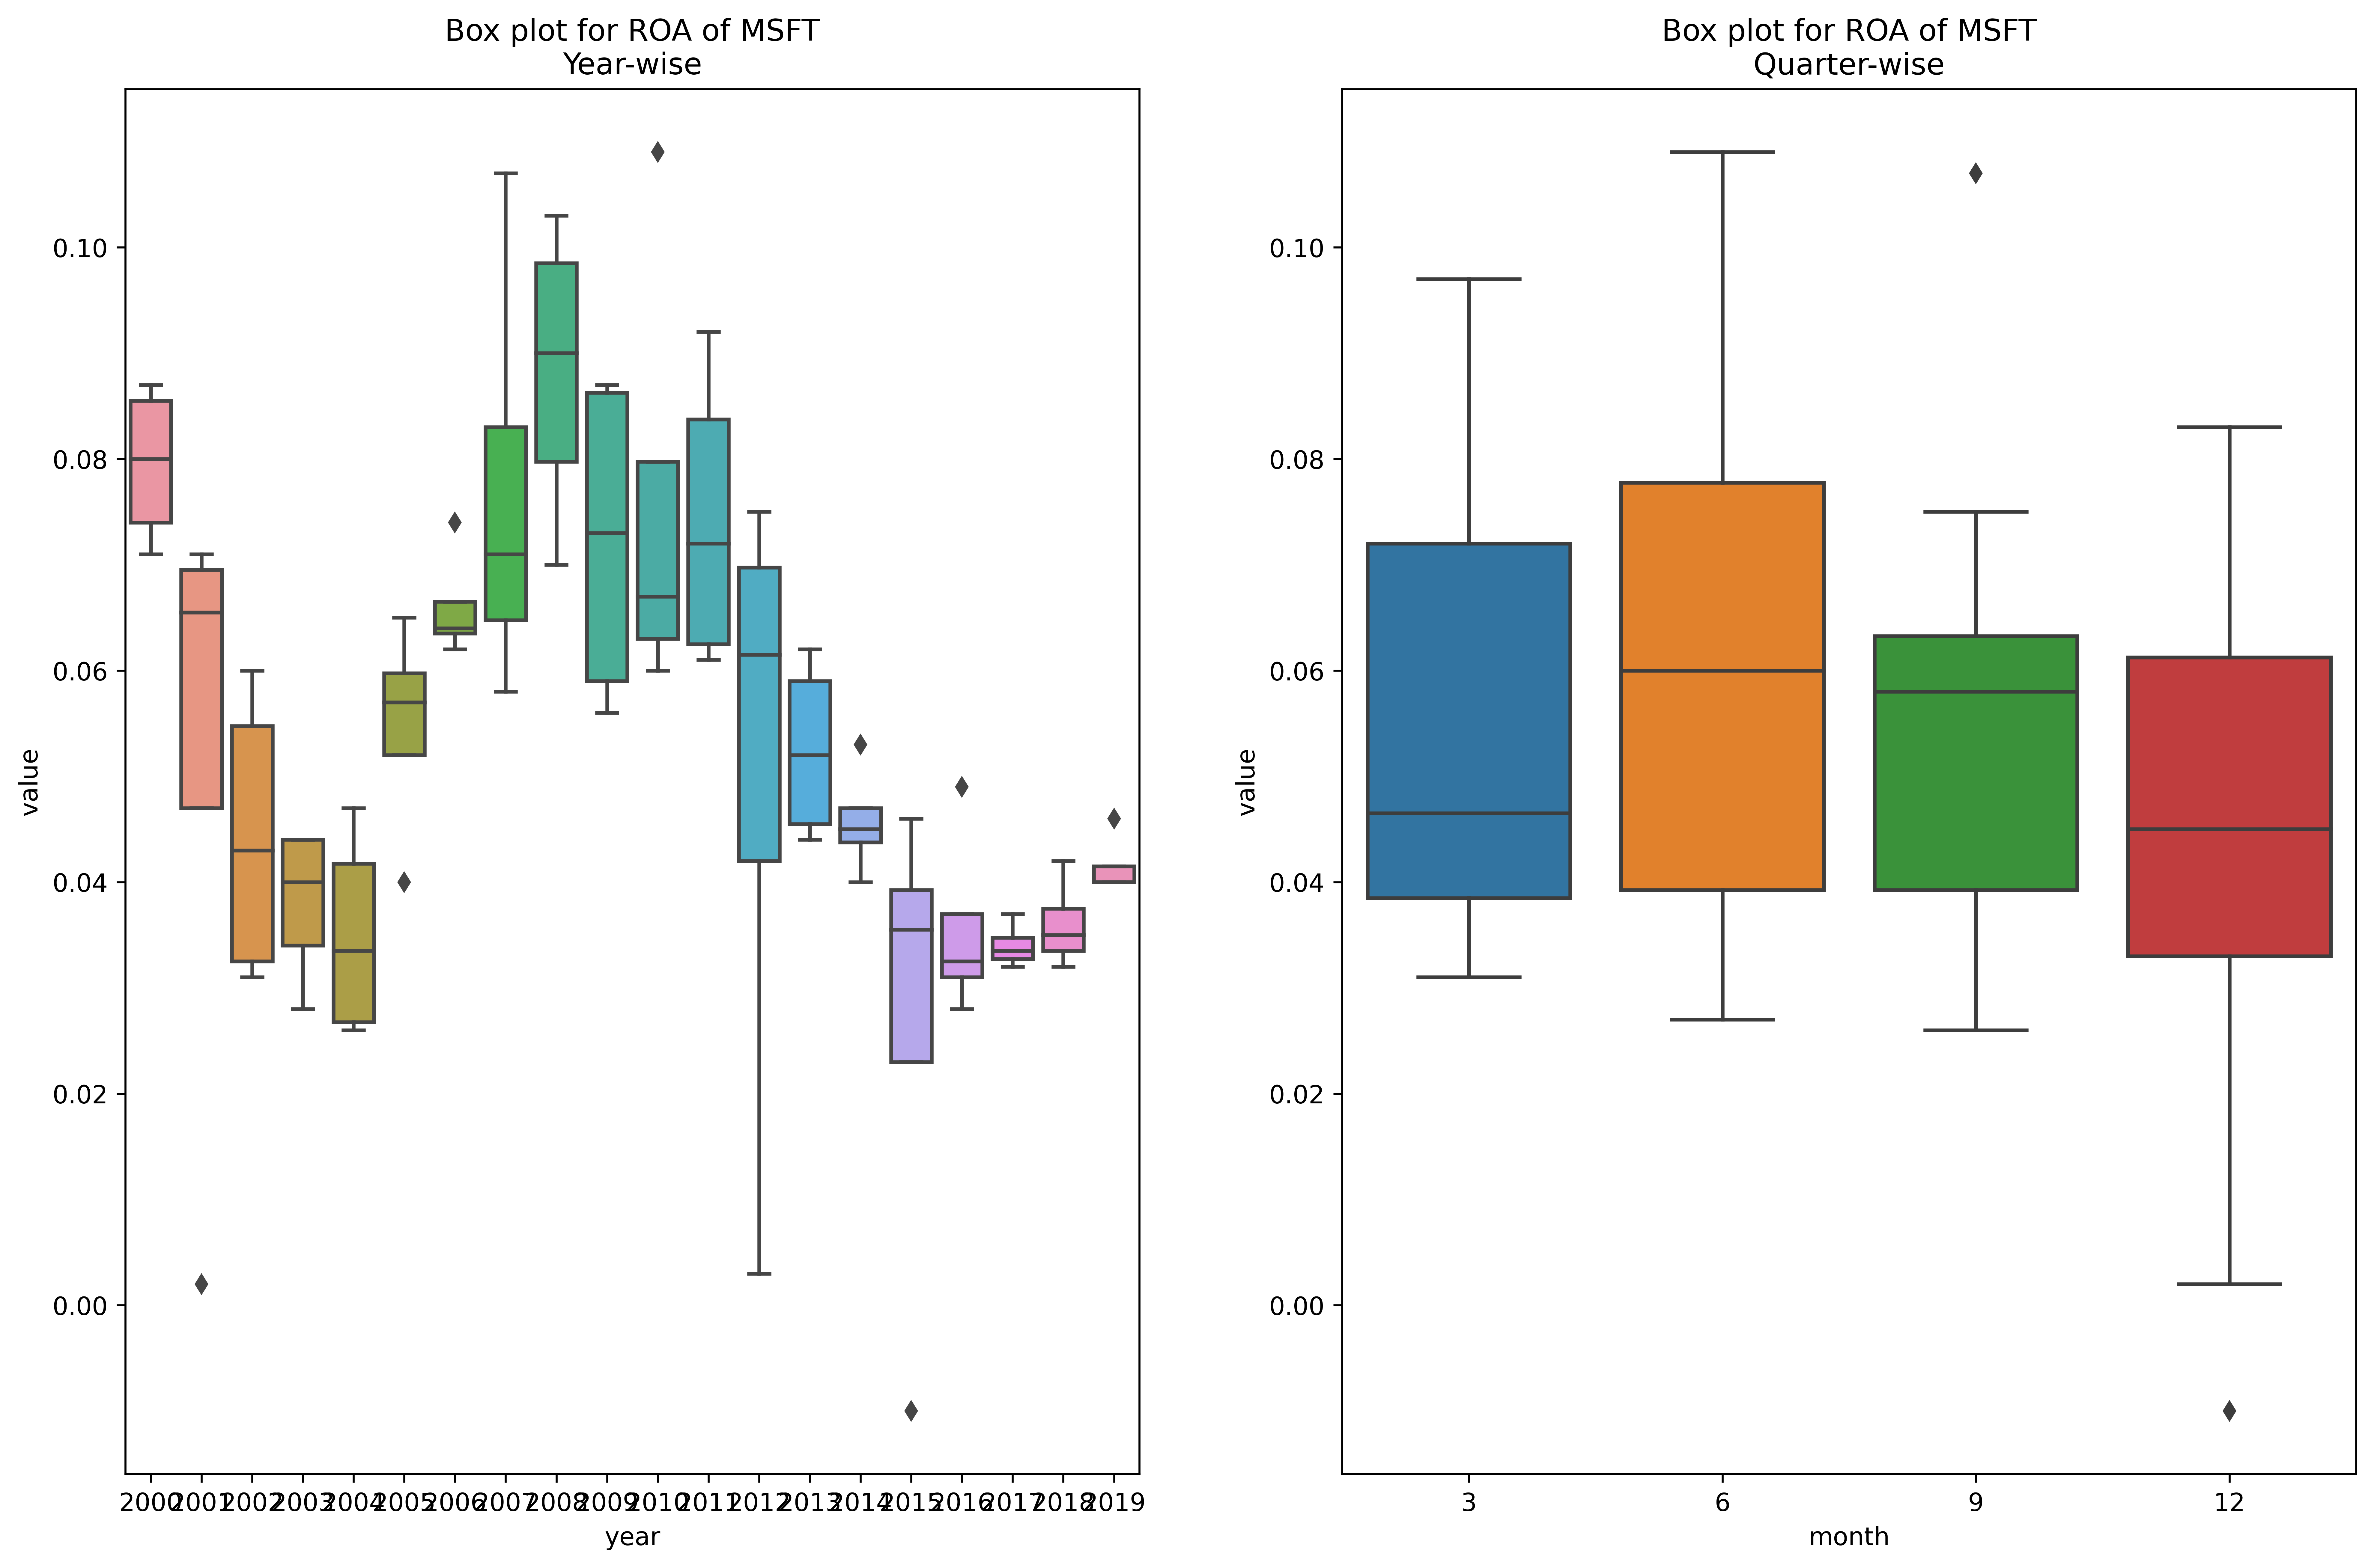

In [10]:

# Let's further explore the trend and seasonality
fig, ax = plt.subplots(1 ,2, figsize=(16,10), dpi=600)

sns.boxplot(data=df, x="year", y="value", ax=ax[0])
sns.boxplot(data=df, x="month", y="value", ax=ax[1])

ax[0].set_title(f"Box plot for ROA of {symbol}\nYear-wise")
ax[1].set_title(f"Box plot for ROA of {symbol}\nQuarter-wise")

plt.show()

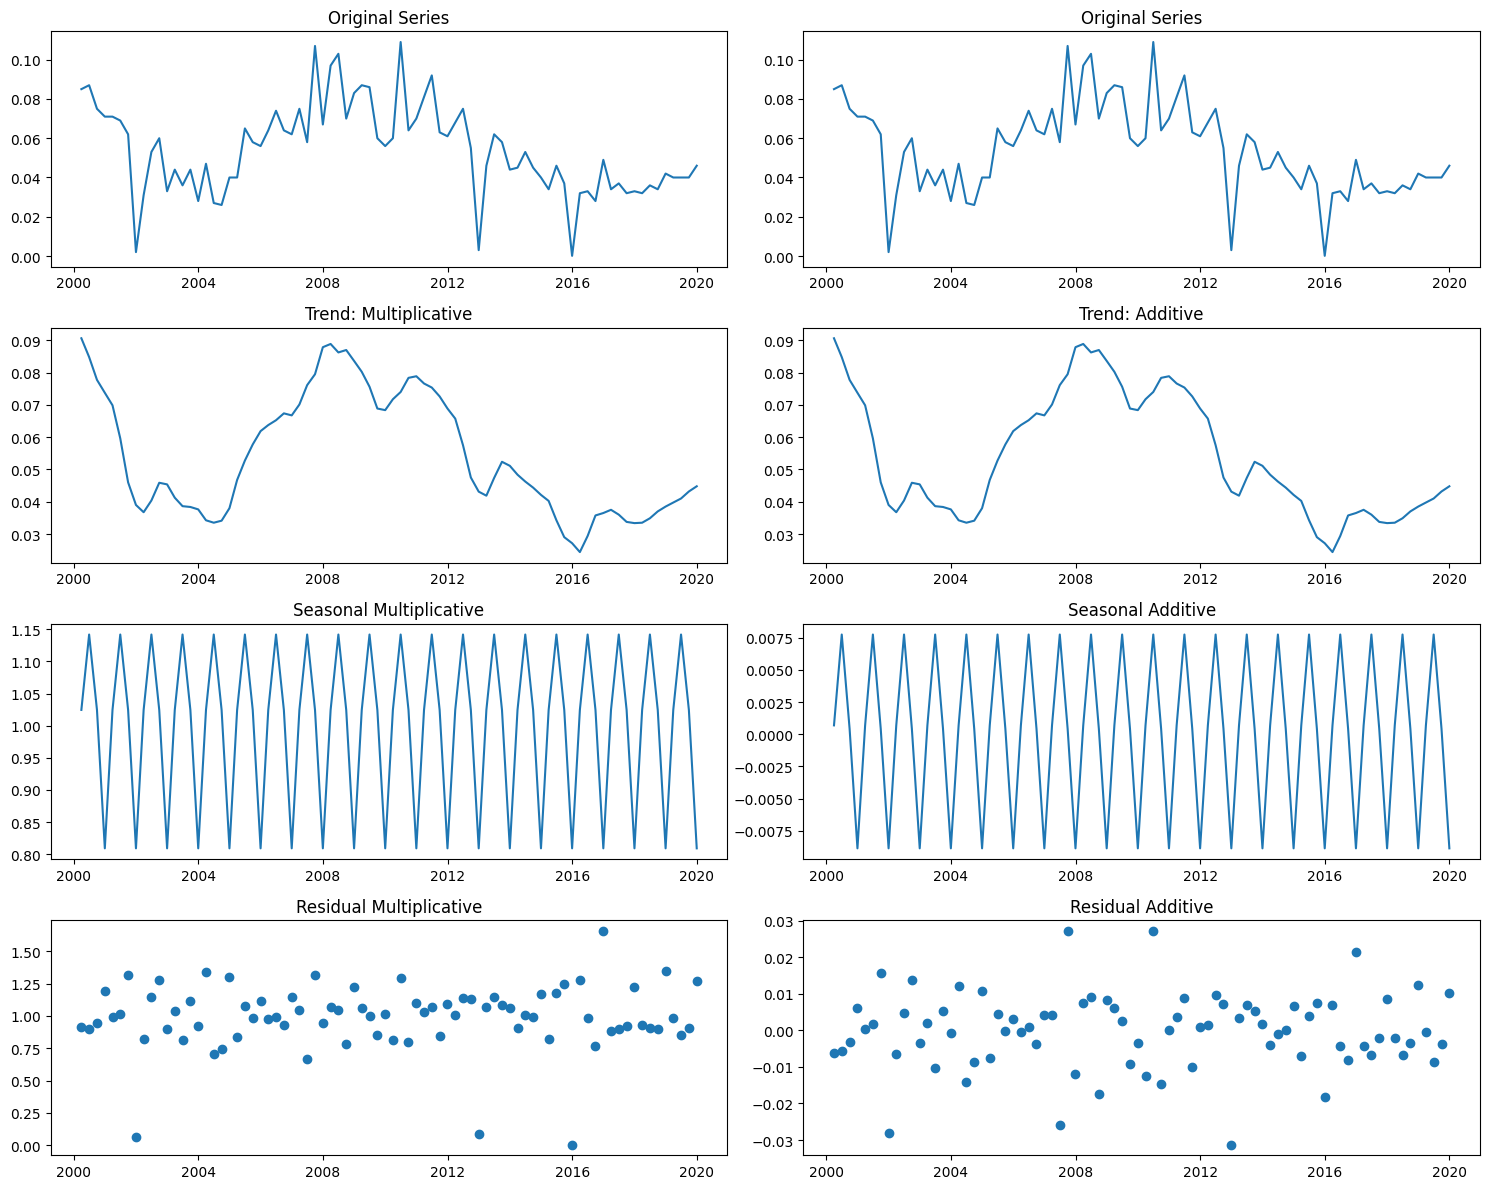

In [11]:
# Let's decompose the time series to further understand it
df.loc[df["value"]<0, "value"] = 0.0001 # Negative values inhbit us from performing multiplicative decomposition

temp = df.set_index("date")["value"]
temp.asfreq("Q")

mult_decomposition = seasonal_decompose(temp, model="multiplicative", extrapolate_trend="freq")
add_decomposition = seasonal_decompose(temp, model="additive", extrapolate_trend="freq")

def plot_decompositions(decompositions: dict):
    fig, axs = plt.subplots(4, len(decompositions), figsize=(15, 12)) # Create 4 rows for original, trend, seasonal, and residual components

    for i, (key, value) in enumerate(decompositions.items()):
        # Plotting the original series and each component of the multiplicative decomposition
        axs[0, i].plot(value.observed)
        axs[0, i].set_title('Original Series')
        axs[1, i].plot(value.trend)
        axs[1, i].set_title(f'Trend: {key}')
        axs[2, i].plot(value.seasonal)
        axs[2, i].set_title(f'Seasonal {key}')
        axs[3, i].scatter(value.resid.index, value.resid.values)
        axs[3, i].set_title(f'Residual {key}')

    plt.tight_layout()
    plt.show()

plot_decompositions({"Multiplicative": mult_decomposition,
                    "Additive": add_decomposition})


Multiplicative decomposition doesn't do us any good. We'll stick with additive.

In [12]:
# Let's explore the stationarity of the the series

# Is it stationary?
result = adfuller(df.value, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

# KPSS Test
result = kpss(df.value, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

ADF Statistic: -1.740891666631916
p-value: 0.4101764652799099
Critial Values:
	1%, -3.5319549603840894
Critial Values:
	5%, -2.905755128523123
Critial Values:
	10%, -2.5903569458676765

KPSS Statistic: 0.432371
p-value: 0.063202
Critial Values:
	10%, 0.347
Critial Values:
	5%, 0.463
Critial Values:
	2.5%, 0.574
Critial Values:
	1%, 0.739


N0 is not rejected in ADF test and N0 is rejected in KPSS test. This hints to the fact that the time series might not be stationary. We set our significance level to 7%, this means that we are accepting a 7% chance of making a type 1 error, i.e: rejecting N0 when it is true. This is a bit high, but we'll stick with it for now.

In [13]:
# We have to make the series stationary to be able to forecast future values


### Is this time series helpful at forecasting another? Say, returns?

In [14]:
# Load or download returns
quarterly_returns, daily_returns = StockReturnsCalculator(os.path.join("..", "data", "pickled_data", "returns_data.pickle")).get_returns(ROA_df.columns.to_list())


..\data\pickled_data\returns_data.pickle
